Objectives 

Answer business requirement 1:
    The client is interested in conducting a study to visually differentiate a healthy cherry leaf from one with powdery mildew.

Inputs

split_data/train
split_data/validation
split_data/test

Outputs

- Image shape embedding pickle file
- Mean and variability of images per label plot
- Plot to distinguish contrast between mildew infected leaves, and healthy cherry leaves.
- Generate code that answers business requirement 1, and can be used to build an image montage on Streamlit dashboard. 

(Credit to code institute walkthrough project for demonstrating the use of much of the below code using matplotlib, numpy and tensor for pre-processing images)

Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.set_style("white")
from matplotlib.image import imread

Set working directory

In [2]:
cwd= os.getcwd()

In [3]:
os.chdir('/workspaces/project5-mildrew')
print("You set a new current directory")

You set a new current directory


In [4]:
work_dir = os.getcwd()
work_dir

'/workspaces/project5-mildrew'

Set Input Directories

Set train, validation and test paths.

In [5]:
my_data_dir = 'split_data'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

Set Output Directory

In [6]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
  print('Old version is already available create a new version.')
  pass
else:
  os.makedirs(name=file_path)

Old version is already available create a new version.


Set Label Names

In [7]:
labels = os.listdir(train_path)
print('Label for the images are',labels)

Label for the images are ['powdery_mildew', 'healthy']


Data Visualisation of image data

Image shape - compute the average image size on the training set.

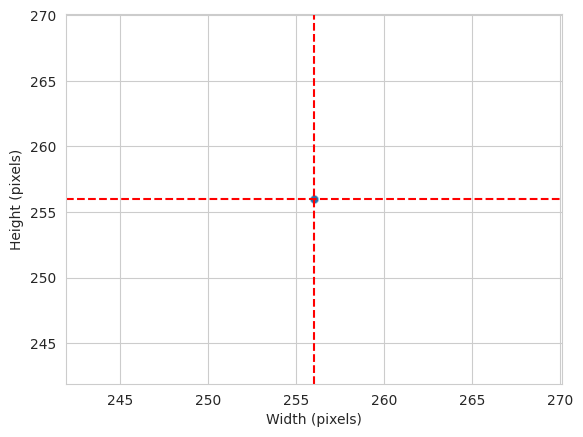

Width average: 256 
Height average: 256


In [8]:
dim1, dim2 = [], []
for label in labels:
  for image_filename in os.listdir(train_path + '/'+ label):
    img = imread(train_path + '/' + label + '/'+ image_filename)
    d1, d2, colors = img.shape
    dim1.append(d1) # image height
    dim2.append(d2) # image width

sns.set_style("whitegrid")
fig, axes = plt.subplots()
sns.scatterplot(x=dim2, y=dim1, alpha=0.2)
axes.set_xlabel("Width (pixels)")
axes.set_ylabel("Height (pixels)")
dim1_mean = int(np.array(dim1).mean())
dim2_mean = int(np.array(dim2).mean())
axes.axvline(x=dim1_mean,color='r', linestyle='--')
axes.axhline(y=dim2_mean,color='r', linestyle='--')
plt.show()
print(f"Width average: {dim2_mean} \nHeight average: {dim1_mean}")

The image size for training the model is the average from all images in the training set.

In [9]:
image_shape = (dim1_mean, dim2_mean, 3)
image_shape

(256, 256, 3)

Save the image shape embeddings

In [10]:
joblib.dump(value=image_shape ,
            filename=f"{file_path}/image_shape.pkl")

['outputs/v1/image_shape.pkl']

Average and variability of images per label

Function for normalising image size, pixels and convert to numpy arrays.

In [11]:
from tensorflow.keras.preprocessing import image

def load_image_as_array(my_data_dir, new_size=(50,50), n_images_per_label=20):
    X_list, y_list = [], []
    labels = os.listdir(my_data_dir)

    for label in labels:
        counter = 0
        for image_filename in os.listdir(f"{my_data_dir}/{label}"):
            if counter < n_images_per_label:
                img_path = f"{my_data_dir}/{label}/{image_filename}"
                img = image.load_img(img_path, target_size=new_size)
                img_resized = image.img_to_array(img)
                if img_resized.max() > 1:
                    img_resized /= 255  

                X_list.append(img_resized)
                y_list.append(label)
                counter += 1

    # Convert lists to numpy arrays
    X = np.array(X_list)
    y = np.array(y_list)  

    return X, y


Load Image shap as array

In [12]:
X, y = load_image_as_array(my_data_dir=train_path,
                           new_size=image_shape,
                          n_images_per_label = 40)
print(X.shape, y.shape)

(80, 256, 256, 3) (80,)


Functions for showing difference between average healthy leaf image, and powdery mildew infected leaf. 

In [13]:
def subset_image_label(X,y,label_to_display):
  y = y.reshape(-1,1,1)
  boolean_mask = np.any(y==label_to_display,axis=1).reshape(-1)
  df = X[boolean_mask]
  return df


def diff_bet_avg_image_labels_data_as_array(X, y, label_1, label_2, figsize=(20,5), save_image=False):
  sns.set_style("white")

  if (label_1 not in np.unique(y)) or (label_2 not in np.unique(y)):
    print(f"Either label {label} or label {label_2}, are not in {np.unique(y)} ")
    return

  # calculate mean from label1
  images_label = subset_image_label(X, y, label_1)
  label1_avg = np.mean(images_label, axis = 0)

  # calculate mean from label2
  images_label = subset_image_label(X, y, label_2)
  label2_avg = np.mean(images_label, axis = 0)

  # calculate difference and plot difference, avg label1 and avg label2
  difference_mean = label1_avg - label2_avg
  fig, axes = plt.subplots(nrows=1, ncols=3, figsize=figsize)
  axes[0].imshow(label1_avg, cmap='gray')
  axes[0].set_title(f'Average {label_1}')
  axes[1].imshow(label2_avg, cmap='gray')
  axes[1].set_title(f'Average {label_2}')
  axes[2].imshow(difference_mean, cmap='gray')
  axes[2].set_title(f'Difference image: Avg {label_1} & {label_2}')
  if save_image:
    plt.savefig(f"{file_path}/avg_diff.png", bbox_inches='tight', dpi=150)
  else:
    plt.tight_layout()
    plt.show()

Run functions on the dataset.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


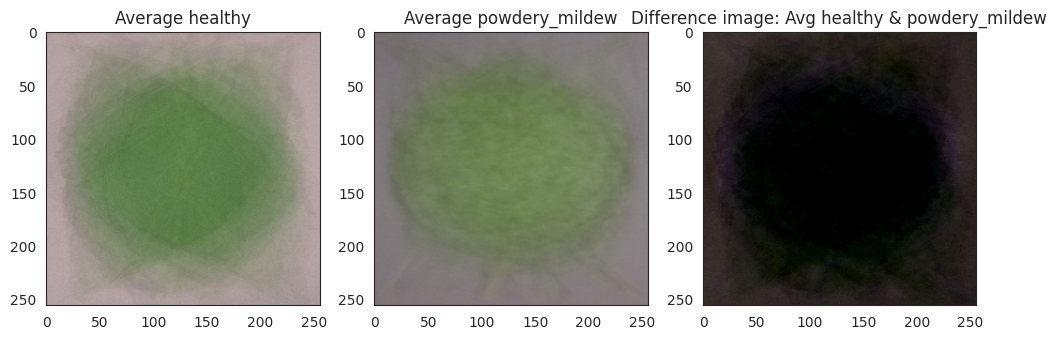

In [16]:
diff_bet_avg_image_labels_data_as_array(X=X, y=y,
                                        label_1='healthy', label_2='powdery_mildew',
                                        figsize=(12,10),
                                        save_image=True
                                        )